<font size=7> HC112823 Buzsaki Latencies 

<font color="red"> In sanity curation, required there to be at least 20 latencies

# Import stuff, get data

I attempt to get Sury's code for analyzing connectivity working.

In [2]:
from scipy.ndimage import gaussian_filter1d

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import math
from scipy.sparse import csr_array
import pickle
import random


import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, read_phy_files,\
                                  plot_latency_dist_hist, plot_latency_angle_hist, read_autocurated_data
from human_hip.animate import animate_latencies

In [2]:
with open('/workspaces/human_hippocampus/data/ephys/2023-05-10-e-hc52_18790_unperturbed/5-10-23s1-CutData.pkl', 'rb' ) as my_file:
    sd = pickle.load(my_file)

# <font color="grey"> Helper Code


Code is adapted from `latencies.py` in the `src` folder

## <font color="grey"> latencies

In [3]:

import numpy as np
from scipy.signal import correlate, correlation_lags



def latencies(neuron1, neuron2, sd, ms_cutoff_low=0, ms_cutoff_high=20 ):
    """
    Function:
        returns all the latencies that occur between two neurons, n1 and n2. 
        A latency is defined as the time difference between a spike from n1 and the nearest spike from n2 (positive or negative)
    Inputs:
        neuron1 (integer): index of the neuron, n1 
        neuron2 (integer): index of the neuron, n2, *note* if n1 occurs before n2, the latency will be positive
        sd (SpikeData object): contains the original spike data from the recording
        ms_cutoff (integer): the maximum latency to be considered, in milliseconds
    Outputs:
        cur_latencies (np.array): the time difference between n1 and n2, for ever latency occurence less than ms_cutoff
    """
    train1 = sd.train[ neuron1 ]
    train2 = sd.train[ neuron2 ]    
    cur_latencies = []
    for time in train1:
        abs_diff_ind = np.argmin(np.abs(train2 - time))  # Subtract time from all spikes in the train and take the absolute value        
        latency = np.array(train2)-time       # Calculate the actual latency
        latency = latency[abs_diff_ind]

        if np.abs(latency) <= ms_cutoff_high and np.abs(latency) >= ms_cutoff_low : # Only append latencies within a certain time cutoff
            cur_latencies.append(latency)
    return np.array(cur_latencies)



## <font color="grey"> Cross Sttc

<font color="orange">I change the original code to calculate the cross sttc from -50-50ms instead of -1000-1000ms. This is done to speed up the calculation.

In [4]:

def cross_sttc( n1, n2, sd, delt=20 ):
    """
    Function: Calculates the cross correlation from -1000ms to 1000ms, expcept using the spike time tiling coefficient, between two neurons, n1 and n2
    Inputs:
        n1 (integer): index of the neuron, n1 
        n2 (integer): index of the neuron, n2
        sd (SpikeData object): contains the original spike data from the recording
        delt (integer): the time window to calculate the spike time tiling coefficient over
    Outputs:
        sttc (float): the spike time tiling coefficient for each shift between n1 and n2
    """
    assert len(sd.neuron_data[0]) == len(sd.train) 
    sttcs = []
    for i in range(-30,31):
        sd.train.append( sd.train[n1]+i )
        sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )
        sd.train.pop(-1)
    return np.array(sttcs)


## <font color="grey">Poission Probability <small> Sury Code

Probability of computing n or more event given lambda_

<font color="orange"> I have to still check that Sury's code is correct

In [5]:
def p_fast(n, lambda_):
    """
    A poisson estimation of the probability of observing n or more events
    """
    ## take log to make sure the factorial does not overflow
    # add poisson_var when x = 0, 1, take log after calculation to avoid log(0)
    if n > 1:
        poisson_01 = [np.exp(-lambda_)*lambda_**x/math.factorial(x) for x in [0, 1]]
        poisson_res = [np.exp(-lambda_ + x*math.log(lambda_) - math.log(math.factorial(x))) for x in range(2, n)]
        poisson_var = poisson_01 + poisson_res
    else:
        poisson_var = [np.exp(-lambda_)*lambda_**x/math.factorial(x) for x in range(n)]
    continuity_correction = np.exp((math.log(0.5) - lambda_ + n*math.log(lambda_)) - math.log(math.factorial(n)))
    return 1 - np.sum(poisson_var) - continuity_correction


# Initial Curation

code is from `curate_latencies` function

In [6]:
sttc_cutoff = 0.04
latency_cutoff=1
sttc_delta=20 

# Get all latencies whose STTC is above some minimum STTC cuttoff
print(sd.N**2 , "Starting Pairs")
sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
for i in range(sd.N):
    for j in range(i+1,sd.N):
        if sttc_neo[i,j] > sttc_cutoff:
            pairs.append([i,j])
print( len(pairs), "pairs above sttc cutoff")

# Get all latencies whose median latency is above some minimum Latency Cuttoff
pairs_late = [] #lags_late = []
for pair in pairs:
    pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=20)  #latency= np.median(pair_latencies)
    if abs(np.median(pair_latencies)) > latency_cutoff  and len(pair_latencies)>30 :
        pairs_late.append( pair )  #lags_late.append( latency )
pairs= pairs_late
print( len(pairs_late), "pairs above latencency cutoff")





10000 Starting Pairs
1414 pairs above sttc cutoff
157 pairs above latencency cutoff


# Buzsaki Method STTC

<font color="orange"> Original paper only considered lags between 0.8-2.8ms. We consider broader range

<font color="red"> Start by doing function for 1 pair

In [7]:
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=8

In [8]:
pairs_pois = []
for pair in pairs:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)
    if p_val < 0.0005:
        pairs_pois.append( pair )
pairs_pois = np.array(pairs_pois)

/tmp/ipykernel_17960/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_17960/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


In [9]:
len(pairs_pois)

70

In [10]:
pairs_good = pairs_pois

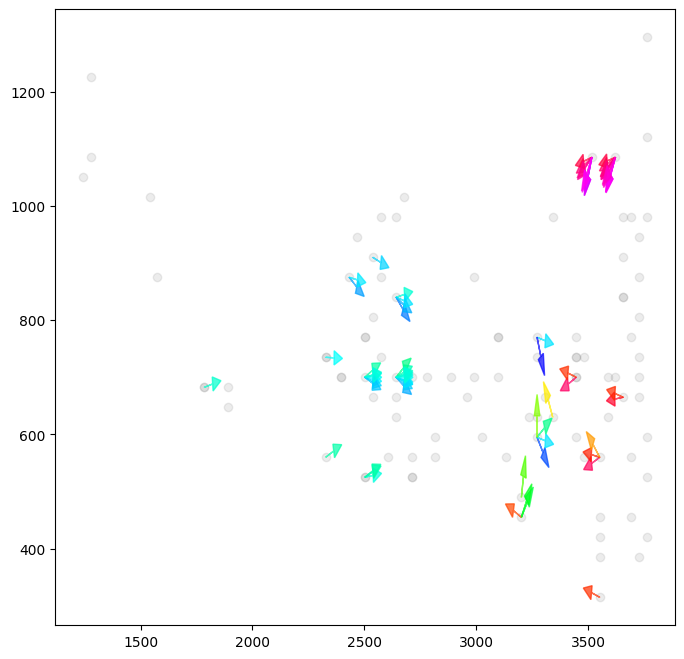

In [11]:
plot_vector_layout( sd, pairs_good )

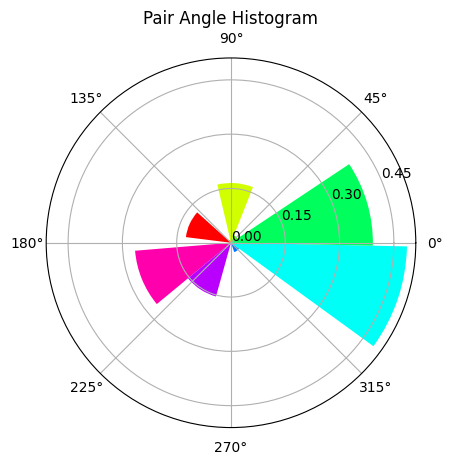

In [12]:
plot_latency_angle_hist(sd, pairs_pois , by_firing_rate=True)


# Buzsaki - Anticausal

In [13]:
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=8

In [14]:
pairs = pairs_pois
pairs_pois = []
for pair in pairs:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)

    anti_sttcs_cutoff = sttcs[30-cross_sttc_max_cutoff:30-cross_sttc_min_cutoff]
    max_arg_cutoff = np.argwhere(anti_sttcs_cutoff == np.amax(anti_sttcs_cutoff))[0][-1] 
    max_arg = max_arg_cutoff+30-cross_sttc_max_cutoff
    pois_lambda = sttcs_smth[max_arg]
    anti_p_val = p_fast(pois_n, pois_lambda)

    if p_val < 0.0005 and anti_p_val<0.0005:
        pairs_pois.append( pair )
pairs_pois = np.array(pairs_pois)

/tmp/ipykernel_17960/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_17960/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


In [15]:
len(pairs_pois)

63

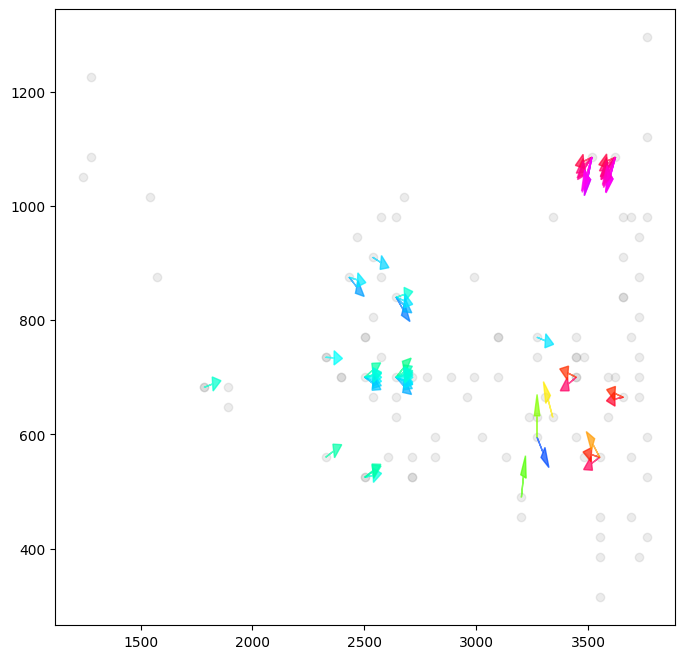

In [16]:
plot_vector_layout( sd, np.array(pairs_pois) )

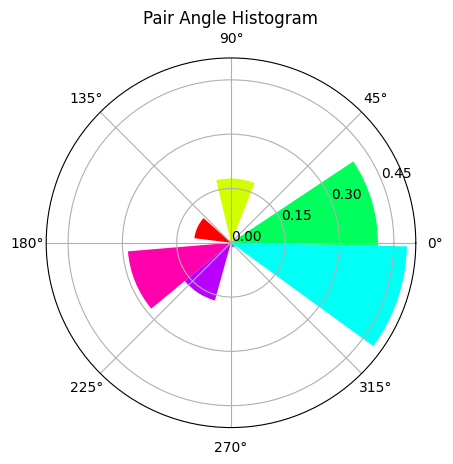

In [17]:
plot_latency_angle_hist(sd, pairs_pois , by_firing_rate=True)

# <font color="red"> OLD

In [30]:
#pair=pairs[0]
#
#pair

In [28]:
sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
pois_n = max_arg_cutoff+cross_sttc_min_cutoff
max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
pois_lambda = sttcs_smth[max_arg]
p_val = p_fast(pois_n, pois_lambda)

#max_args = np.argwhere(sttcs == np.amax(sttcs)) - 1000 
#cross_lag.append( max_args[np.argmin(np.abs(max_args))][0] )   # if multiple maxima, take the one closest to zero

/tmp/ipykernel_404/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_404/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


In [24]:
pois_lambda

0.16314259748228155

In [22]:
sttcs_smth[max_arg]

0.16314259748228155

In [15]:
pois_n

1

In [16]:
max_arg

31

In [17]:
max_arg_cutoff

0

In [19]:
max_arg

31

In [56]:
sttcs[max_arg], sttcs_smth[max_arg]

(0.17390236731548497, 0.16314259748228155)

In [59]:
pois_n = max_arg_cutoff+cross_sttc_min_cutoff

In [60]:
pois_n

1

In [50]:
max_arg

31

0

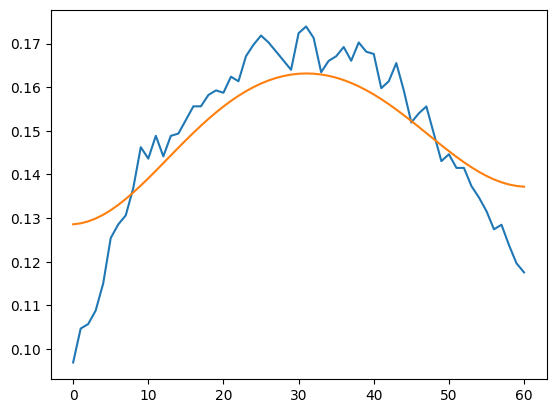

In [13]:

sttcs
# Create a plot
plt.plot(sttcs)  # plots the numbers against their index
plt.plot(sttcs_smth)  # plots the numbers against their index

31

In [ ]:
# Do cross sttc for all pairs
print("Starting cross_sttc calculation... might take a minute")
cross_lag  = [] 
for pair in pairs: 
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
    max_args = np.argwhere(sttcs == np.amax(sttcs)) - 1000 
    cross_lag.append( max_args[np.argmin(np.abs(max_args))][0] )   # if multiple maxima, take the one closest to zero
cross_lag = np.array(cross_lag)
to_keep = np.where((np.abs(cross_lag)< cross_sttc_max_cutoff) & (np.abs(cross_lag)> cross_sttc_min_cutoff) & (cross_lag!=0) )[0]
print( len(to_keep), "pairs between cross_sttc cutoffs")
